In [1]:

!pip install contractions scikit-learn==1.3.2 nltk spacy wordcloud

!pip install --upgrade pip

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 85.4 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 83.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: thinc
    Found existing installation: thinc 8.3.6
    Uninstalling thinc-8.3.6:
      Successfully uninstalled thinc-8.3.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires nump

In [2]:
import re
import os
import joblib
import nltk
import spacy
import contractions
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

2025-11-25 15:33:04.577227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764084784.762118      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764084784.816443      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
all_data=pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')
all_data.columns=['target','id','data','quary','user','text']
data=all_data[['target','text']]

In [4]:
data['target'].value_counts()

target
0    799996
4    248576
Name: count, dtype: int64

In [5]:
data = data[['target', 'text']]
data['target'] = data['target'].replace(4, 1)
data.shape

(1048572, 2)

In [6]:
data.isnull().sum()


target    0
text      0
dtype: int64

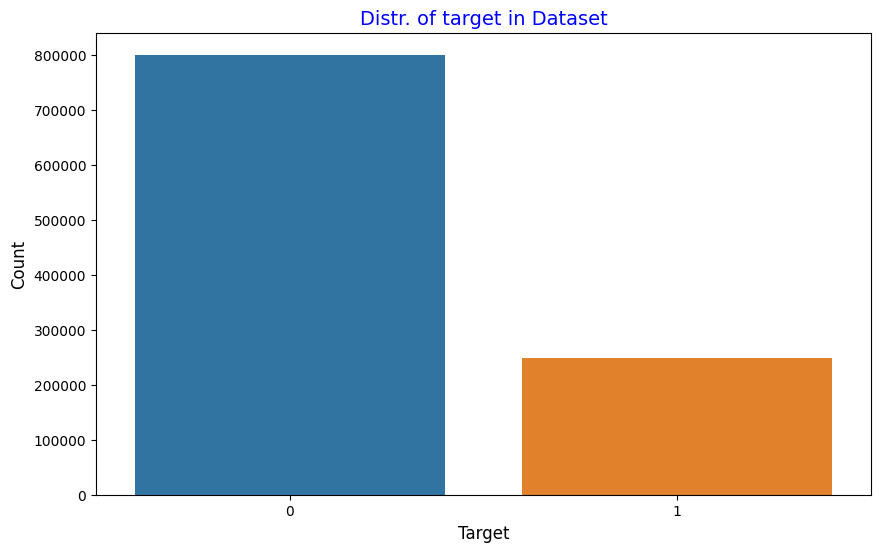

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='b')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


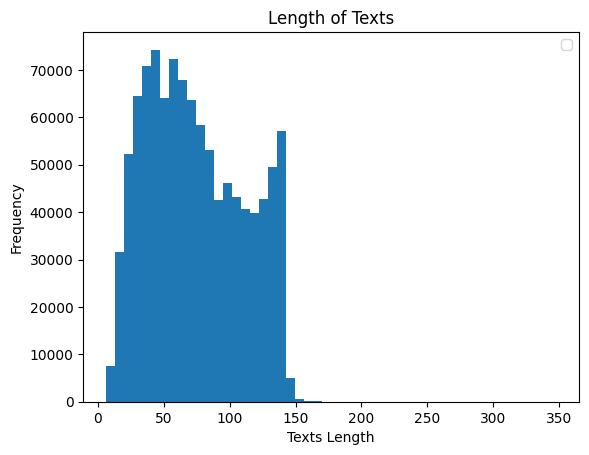

In [8]:
length_train = data['text'].str.len()
plt.hist(length_train, bins=50)
plt.legend()
plt.title('Length of Texts')
plt.xlabel('Texts Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
from sklearn.utils import resample

majority = data[data['target'] == 0]
minority = data[data['target'] == 1]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

balanced_data = pd.concat([majority, minority_upsampled])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


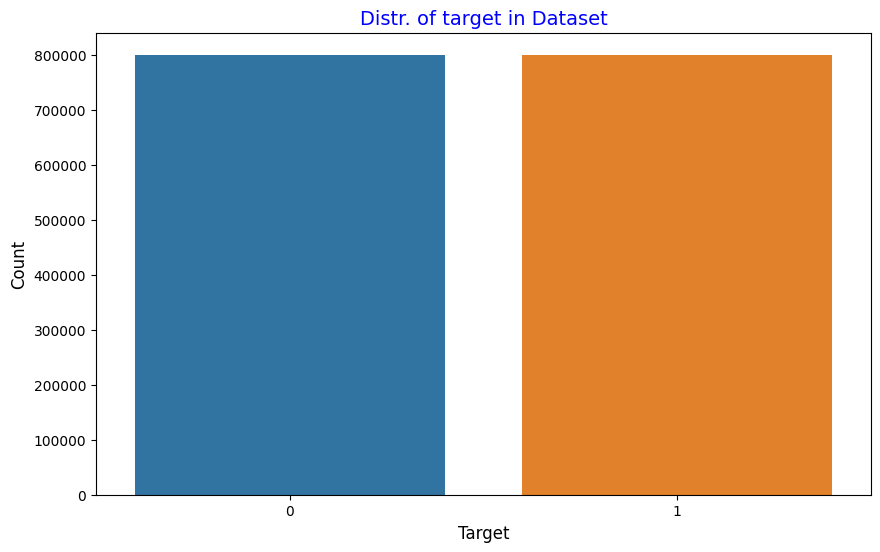

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_data, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='b')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [11]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}

def remove_repeated_characters(text, max_repeats=2):
    """Remove repeated characters, e.g., 'loooove' becomes 'love'."""
    pattern = r"(.)\1{%d,}" % (max_repeats - 1)
    return re.sub(pattern, r"\1", text)

def remove_mentions(text):
    """Remove mentions (e.g., @user) from the text."""
    return re.sub(r"@[\w]*", '', text)

def remove_links(text):
    """Remove URLs from the text."""
    return re.sub(r"https?://\S+|www\.\S+", '', text)


def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead '''
    for emoticon, meaning in emoticon_meanings.items():
         text = text.replace(emoticon, '' + meaning + '')
    return text

def remove_punctuations(text):
    """Remove punctuation and non-alphabetic characters, except for apostrophes."""
    return re.sub(r"[^a-zA-Z\s']", '', text)

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize the text."""
    tokenized_text = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokenized_text])


def clean_text(text):
    """
    Apply all text preprocessing steps in order.
    """
    text = text.lower().strip()
    text = remove_links(text)
    text = remove_mentions(text)
    text = remove_repeated_characters(text)
    text = convert_emoticons(text)
    text = remove_punctuations(text)
    text = tokenize_and_lemmatize(text)
    text = text.lower()
    text = ' '.join(text.split())  # remove redundant spaces
    return text


In [12]:


tqdm.pandas()
balanced_data['clean_text'] = balanced_data['text'].progress_apply(clean_text)

100%|██████████| 1599992/1599992 [03:31<00:00, 7547.92it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


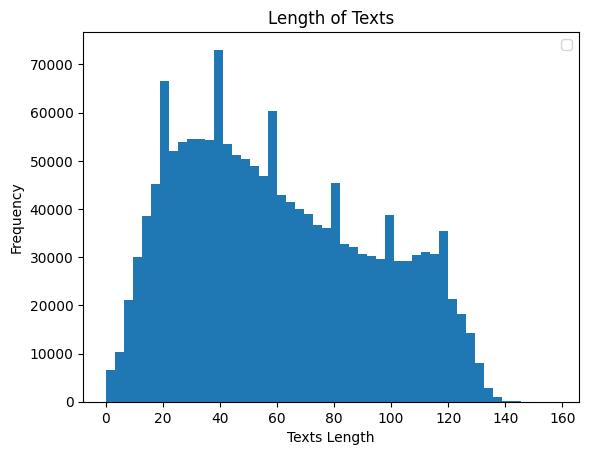

In [13]:
length_train = balanced_data['clean_text'].str.len()
plt.hist(length_train, bins=50)
plt.legend()
plt.title('Length of Texts')
plt.xlabel('Texts Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
balanced_data.shape

(1599992, 3)

In [15]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_data['clean_text'])
joblib.dump(tokenizer, "/kaggle/working/tokenizer.pkl")


['/kaggle/working/tokenizer.pkl']

In [16]:
sequences = tokenizer.texts_to_sequences(balanced_data['clean_text'])


In [17]:
max_len = max(len(seq) for seq in sequences)
open("/kaggle/working/max_len.txt","w").write(str(max_len))
max_len

40

In [18]:
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [19]:
X = padded
y = balanced_data['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
def plot_history(history, model_name):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_val, y_val, name):
    y_pred = (model.predict(X_val) > 0.5).astype(int).reshape(-1)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()



In [22]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [23]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [24]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_rnn.add(SimpleRNN(64))
#model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(16,activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-5)
model_rnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1764085059.091084      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [25]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=1024,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/15


I0000 00:00:1764085061.977341     125 service.cc:148] XLA service 0x7b5a980d4eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764085061.977845     125 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764085062.408748     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  16/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5057 - loss: 0.6955

I0000 00:00:1764085063.981479     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5475 - loss: 0.6770 - val_accuracy: 0.7407 - val_loss: 0.5573
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7296 - loss: 0.5633 - val_accuracy: 0.7743 - val_loss: 0.5040
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7746 - loss: 0.5203 - val_accuracy: 0.7892 - val_loss: 0.4717
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7959 - loss: 0.4867 - val_accuracy: 0.7993 - val_loss: 0.4498
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8044 - loss: 0.4677 - val_accuracy: 0.8035 - val_loss: 0.4391
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8103 - loss: 0.4548 - val_accuracy: 0.8077 - val_loss: 0.4296
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8146 - loss: 0.4448 - val_accuracy: 0.8104 - val_loss: 0.4231
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8171 - loss: 0.43

In [26]:
print(model_rnn.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,627,941 (36.73 MB)

 Trainable params: 3,209,313 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,418,628 (24.49 MB)

None


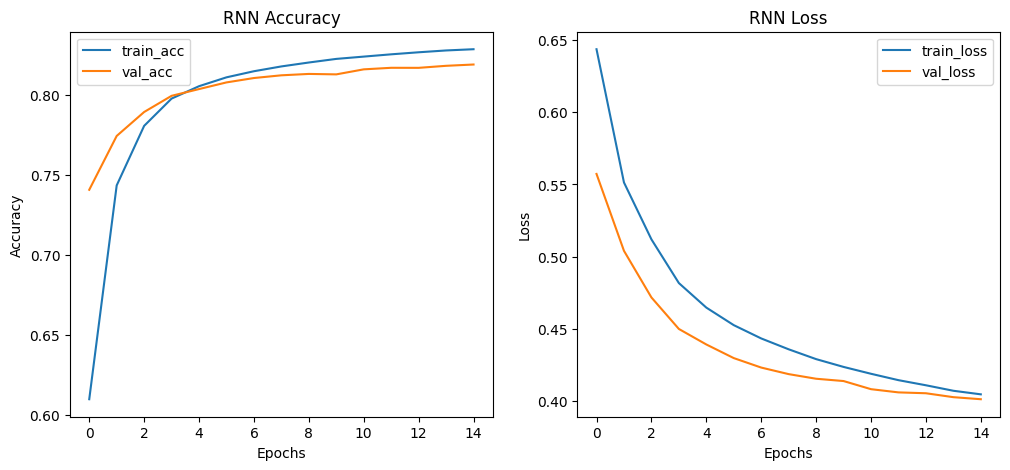

In [27]:
plot_history(history_rnn, 'RNN')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
RNN Validation Accuracy: 0.8189


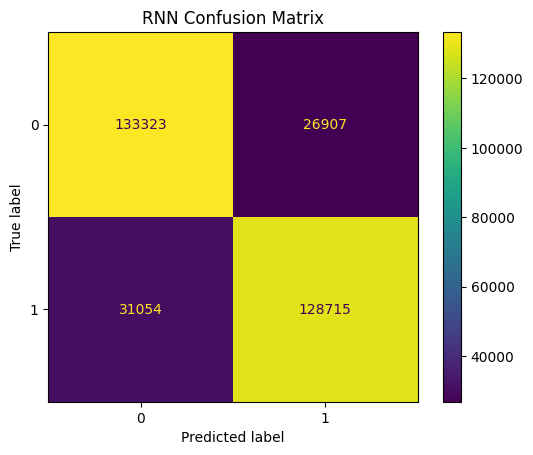

In [28]:
evaluate_model(model_rnn, X_val, y_val, 'RNN')

In [29]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_gru.add(Bidirectional(GRU(64)))
#model_gru.add(Dropout(0.5)) 
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dropout(0.5)) 
model_gru.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-5)
model_gru.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.5279 - loss: 0.6916 - val_accuracy: 0.6186 - val_loss: 0.6839
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5927 - loss: 0.6793 - val_accuracy: 0.6675 - val_loss: 0.6506
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6585 - loss: 0.6365 - val_accuracy: 0.7432 - val_loss: 0.5526
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7355 - loss: 0.5639 - val_accuracy: 0.7706 - val_loss: 0.5152
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7593 - loss: 0.5357 - val_accuracy: 0.7765 - val_loss: 0.4972
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7695 - loss: 0.5215 - val_accuracy: 0.7873 - val_loss: 0.4841
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7778 - loss: 0.5095 - val_accuracy: 0.7921 - val_loss: 0.4754
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7836 - loss: 0.5004 - 

In [31]:
print(model_gru.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,756,005 (37.22 MB)

 Trainable params: 3,252,001 (12.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,504,004 (24.81 MB)

None


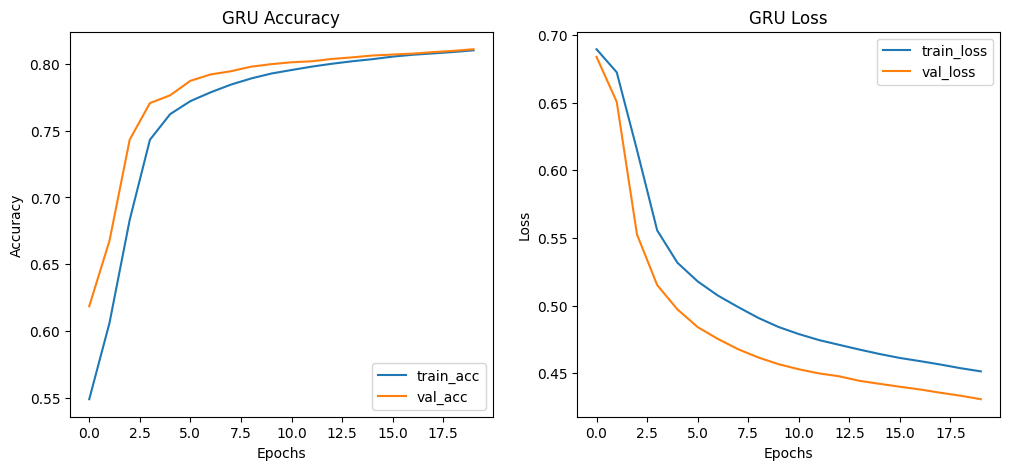

In [32]:
plot_history(history_gru, 'GRU')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
GRU Validation Accuracy: 0.8110


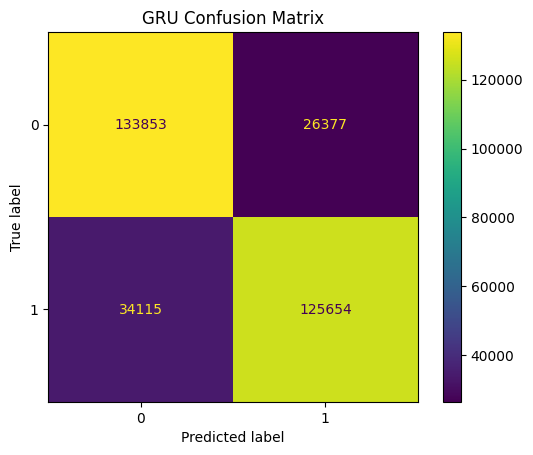

In [33]:
evaluate_model(model_gru, X_val, y_val, 'GRU')

In [34]:


model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(Dropout(0.3)) 
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dropout(0.5)) 
model_lstm.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=3e-5)
model_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=1024,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.5969 - loss: 0.6609 - val_accuracy: 0.7735 - val_loss: 0.5151
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7638 - loss: 0.5216 - val_accuracy: 0.7936 - val_loss: 0.4598
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.7895 - loss: 0.4777 - val_accuracy: 0.8034 - val_loss: 0.4381
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8022 - loss: 0.4517 - val_accuracy: 0.8080 - val_loss: 0.4235
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8090 - loss: 0.4371 - val_accuracy: 0.8114 - val_loss: 0.4153
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8134 - loss: 0.4265 - val_accuracy: 0.8122 - val_loss: 0.4107
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8173 - loss: 0.4186 - val_accuracy: 0.8144 - val_loss: 0.4056
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8202 -

In [36]:
print(model_lstm.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,804,389 (37.40 MB)

 Trainable params: 3,268,129 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,536,260 (24.93 MB)

None


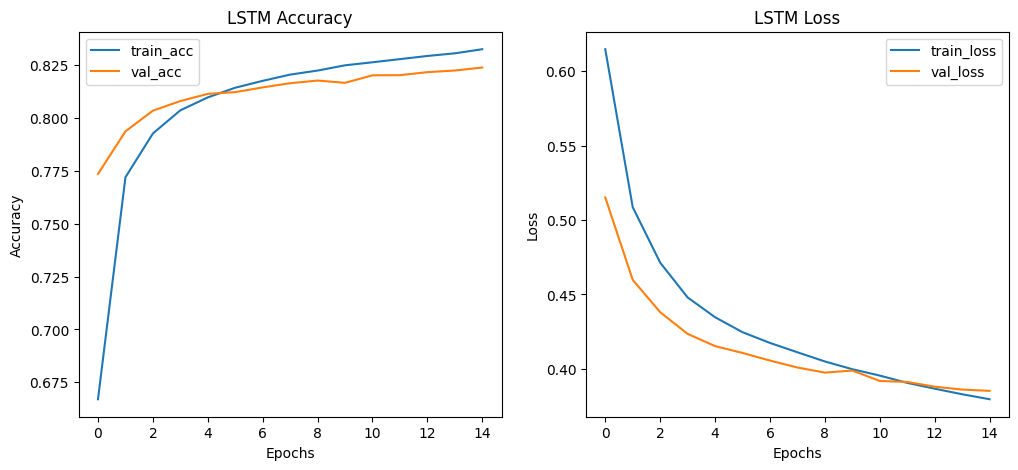

In [37]:
plot_history(history_lstm, 'LSTM')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
LSTM Validation Accuracy: 0.8238


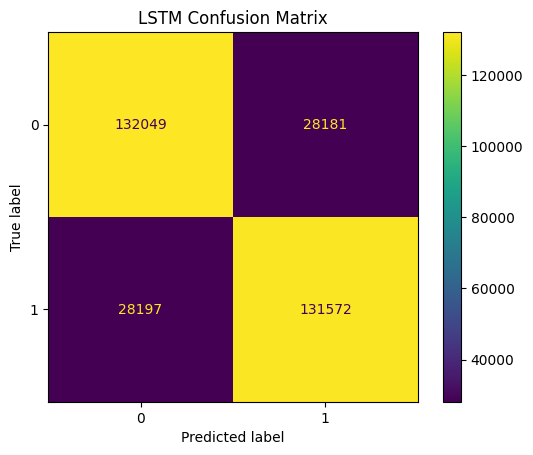

In [38]:
evaluate_model(model_lstm, X_val, y_val, 'LSTM')

In [39]:
model_rnn.save('rnn_model.h5')
model_lstm.save('lstm_model.h5')
model_gru.save('gru_model.h5')